In [1]:
import os
import re
import glob
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set()
# sns.set_style("whitegrid", {'grid.linestyle': '--'})
# sns.set_context("paper", 1.5, {"lines.linewidth": 4})
# sns.set_palette("winter_r", 8, 1)
# sns.set_context("paper", 1.5)
sns.set('paper','whitegrid', font_scale=3, rc={"lines.linewidth": 3, 'grid.linestyle': '--'})

In [2]:
expt_name = "./ray_results/compare-algo-9"
stats_name = "best-stats-eval"

In [3]:
last_stats_folders = glob.glob(os.path.join(expt_name, "*", "last-stats-eval"))
best_stats_folders = glob.glob(os.path.join(expt_name, "*", "best-stats-eval"))
best_stats_folders

['./ray_results/compare-algo-9\\A2C_10-20_22-08_fjnuxi5\\best-stats-eval',
 './ray_results/compare-algo-9\\DQN_10-20_21-070s31eisa\\best-stats-eval',
 './ray_results/compare-algo-9\\PPO_10-20_22-27s98gwag3\\best-stats-eval',
 './ray_results/compare-algo-9\\PPO_10-21_12-05xaygsova\\best-stats-eval',
 './ray_results/compare-algo-9\\Rainbow_10-20_21-33ewq3r7s6\\best-stats-eval',
 './ray_results/compare-algo-9\\SAC_10-20_22-570humhmsa\\best-stats-eval']

In [9]:
summary_equity_curve = {}
summary_performance = {}
for folder in best_stats_folders:
    print(folder)
    algo = folder.split('\\')[1].split('_')[0]
    equity_curve = pd.read_csv(os.path.join(folder, "equity_curve.csv"), index_col=0)
    performance = pd.read_csv(os.path.join(folder, "performance.csv"))
    summary_equity_curve[algo] = equity_curve
    summary_performance[algo] = performance

./ray_results/compare-algo-9\A2C_10-20_22-08_fjnuxi5\best-stats-eval
./ray_results/compare-algo-9\DQN_10-20_21-070s31eisa\best-stats-eval
./ray_results/compare-algo-9\PPO_10-20_22-27s98gwag3\best-stats-eval
./ray_results/compare-algo-9\PPO_10-21_12-05xaygsova\best-stats-eval
./ray_results/compare-algo-9\Rainbow_10-20_21-33ewq3r7s6\best-stats-eval
./ray_results/compare-algo-9\SAC_10-20_22-570humhmsa\best-stats-eval


In [5]:
for algo, performance in summary_performance.items():
    print(algo)
    print(performance)

A2C
                   Start   2018-01-04 00:00:00
0                    End   2020-12-30 00:00:00
1               Duration    1091 days 00:00:00
2             Return [%]   -18.974669490234287
3  Buy & Hold Return [%]     16.75225282152638
4      Return (Ann.) [%]      -7.0151633901535
5  Volatility (Ann.) [%]    17.335283637209002
6           Sharpe Ratio  -0.33360631338580254
7      Max. Drawdown [%]   -29.920563397613908
DQN
                   Start  2018-01-04 00:00:00
0                    End  2020-12-30 00:00:00
1               Duration   1091 days 00:00:00
2             Return [%]    28.30682758007842
3  Buy & Hold Return [%]    16.75225282152638
4      Return (Ann.) [%]    8.998286968688962
5  Volatility (Ann.) [%]    17.75775490823122
6           Sharpe Ratio   0.5743753835664747
7      Max. Drawdown [%]   -20.58021658517113
PPO
                   Start  2018-01-04 00:00:00
0                    End  2020-12-30 00:00:00
1               Duration   1091 days 00:00:00
2            

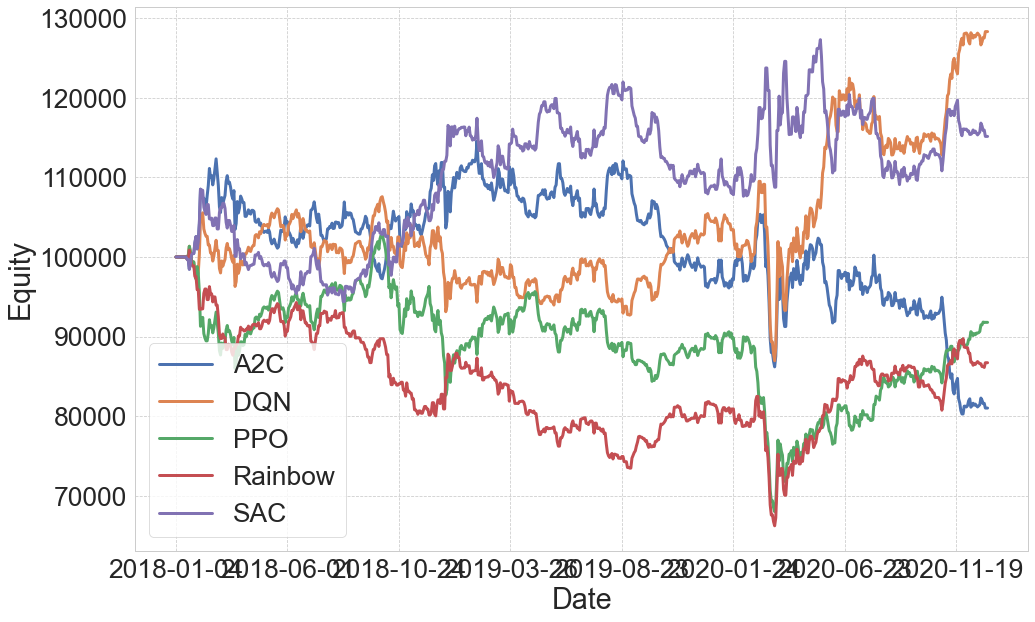

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.set_ylabel('Equity')
ax.set_xlabel('Date')
for algo, equity_curve in summary_equity_curve.items():
    algo_name = algo
    equity_curve["Equity"].plot(ax=ax, label=algo, legend=True)
    # ax.plot(equity_curve["Equity"], label=algo)

In [17]:
folders = glob.glob(os.path.join(expt_name, "*"))
summary_progress = {}
for folder in folders:
    print(folder)
    algo = folder.split('\\')[1].split('_')[0]
    path = os.path.join(folder, "progress.csv")
    progress = pd.read_csv(path)
    summary_progress[algo] = progress[["episode_reward_mean", "evaluation/episode_reward_mean", "timesteps_total"]]

./ray_results/compare-algo-9\A2C_10-20_22-08_fjnuxi5
./ray_results/compare-algo-9\DQN_10-20_21-070s31eisa
./ray_results/compare-algo-9\PPO_10-20_22-27s98gwag3
./ray_results/compare-algo-9\Rainbow_10-20_21-33ewq3r7s6
./ray_results/compare-algo-9\SAC_10-20_22-570humhmsa


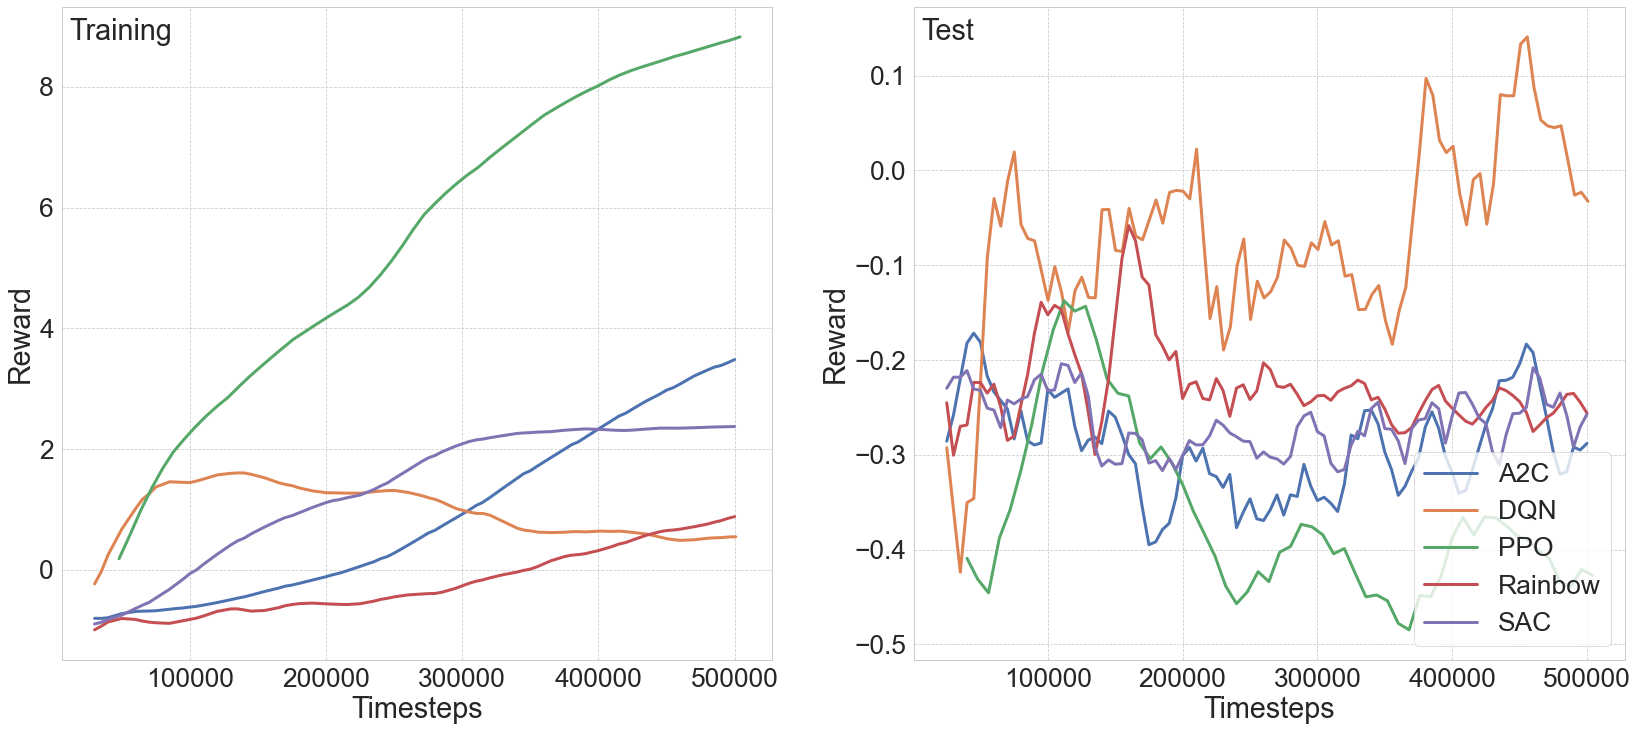

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(28, 12))
axes[0].text(0.01, 0.95, "Training", transform=axes[0].transAxes)
axes[0].set_ylabel("Reward")
axes[0].set_xlabel("Timesteps")
axes[1].text(0.01, 0.95, "Test", transform=axes[1].transAxes)
axes[1].set_ylabel("Reward")
axes[1].set_xlabel("Timesteps")
for algo, progress in summary_progress.items():
    train_rewards = progress["episode_reward_mean"].rolling(5).mean()
    test_rewards = progress["evaluation/episode_reward_mean"].rolling(5).mean()
    axes[0].plot(progress["timesteps_total"], train_rewards, label=algo)
    axes[1].plot(progress["timesteps_total"], test_rewards, label=algo)
    # progress["episode_reward_mean"].ewm(5).mean().plot(x=progress["timesteps_total"], ax=axes[0])
    # progress["evaluation/episode_reward_mean"].ewm(5).mean().plot(x=progress["timesteps_total"], ax=axes[1], label=algo, legend=True).legend(loc='lower right')

axes[1].legend(loc='lower right')